In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import copy
from astropy.io import fits
import astropy.units as u
from astropy.modeling.models import BlackBody

We are following the following equation to get to a BB spectrum:

$$
D(\nu) = e^{i\nu\psi} H(\nu)^{-1} \left(\frac{1}{Z(\omega)B(\omega)} Y(\nu) - C(\nu)\right).
$$

In [2]:
f_nyquist = 145.212 / u.cm
nu = np.arange(210)*(f_nyquist/320) + 2 / u.cm
# nu = nu[:43]
print(max(nu))

f = nu.to(u.GHz, equivalencies=u.spectral())

# print(f)

96.84158749999999 1 / cm


Get interferogram

In [3]:
gmt = b'89326172801540'

fdq_sdf = h5py.File("/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_sdf_new.h5")["fdq_sdf_ll"]
fdq_eng = h5py.File("/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_eng_new.h5")

sci_id = list(fdq_sdf["ct_head/gmt"]).index(gmt)

print(sci_id)

4400


In [4]:
eng_time = fdq_sdf["dq_data/eng_time"][sci_id]
eng_id = list(fdq_eng["ct_head/time"]).index(eng_time)

print(eng_id)

4265


In [5]:
xcal_pos = fdq_sdf["dq_data/xcal_pos"][sci_id]
print(xcal_pos)

2


In [6]:
mtm_length = fdq_sdf["sci_head/mtm_length"][sci_id]
mtm_speed = fdq_sdf["sci_head/mtm_speed"][sci_id]

In [7]:
fake_it = fdq_sdf["dq_data/fake"][sci_id]

In [8]:
upmode = fdq_sdf["sci_head/sc_head1a"][sci_id]

In [9]:
adds_per_group = fdq_sdf["sci_head/sc_head9"][sci_id]

In [10]:
ifg = fdq_sdf["ifg_data/ifg"][sci_id]

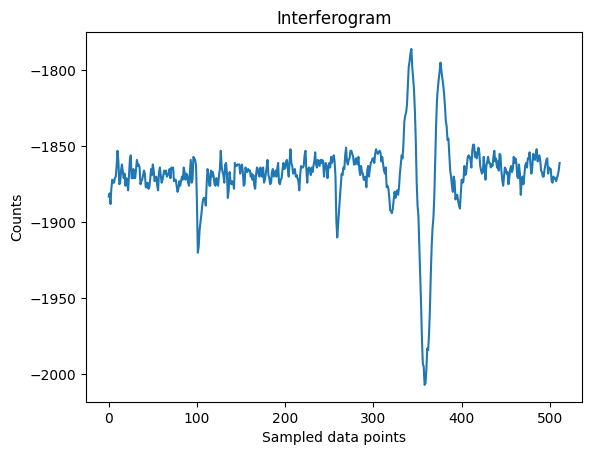

In [11]:
plt.plot(ifg)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Interferogram")
plt.show()

Subtract the dither

In [12]:
ifg = ifg - np.median(ifg)

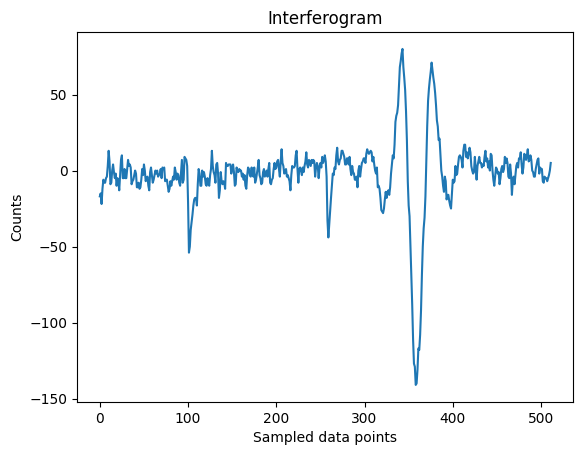

In [13]:
plt.plot(ifg)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Interferogram")
plt.show()

Get rid of the biggest glitches

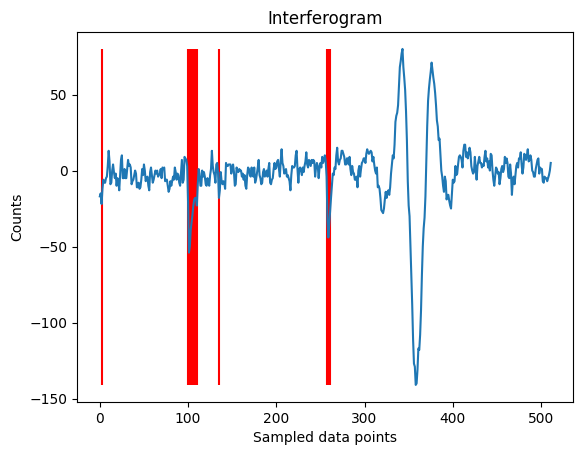

In [14]:
ifg_maxs = copy.deepcopy(ifg)

ordered_maxs = []
for i in range(len(ifg)):
    ordered_maxs.append(np.argmax(np.abs(ifg_maxs)))
    ifg_maxs[ordered_maxs[-1]] = 0

plt.vlines(ordered_maxs[26], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[30], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[34], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[37], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[42:45], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[49], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[53], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[58:60], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[62:64], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[68], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[71:74], np.min(ifg), np.max(ifg), color="red")

plt.plot(ifg)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Interferogram")
plt.show()

In [15]:
averaged_ifg = copy.deepcopy(ifg)

for i in range(len(ifg)//2):
    averaged_ifg[ordered_maxs[i]] = 0

print(np.max(averaged_ifg), np.min(averaged_ifg))

# plt.plot(averaged_ifg)
# plt.xlabel("Sampled data points")
# plt.ylabel("Counts")
# plt.title("Averaged interferogram")
# plt.show()

6.0 -6.0


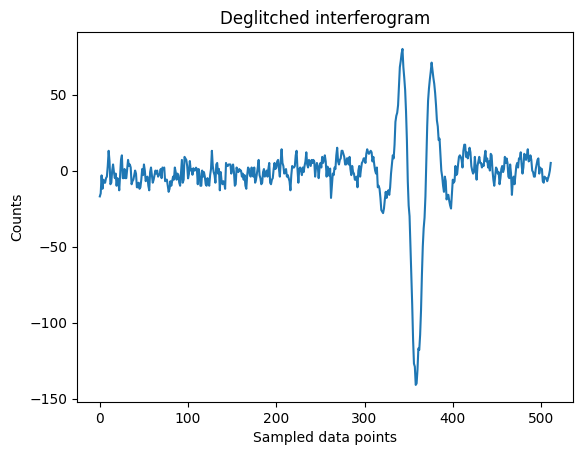

In [16]:
std = np.std(averaged_ifg)

glitch_idx = [26, 30, 34, 37, 42, 43, 44, 49, 53, 58, 59, 62, 63, 68, 71, 72, 73]
deglitched_ifg = copy.deepcopy(ifg)

for i in glitch_idx:
    deglitched_ifg[ordered_maxs[i]] = np.random.normal(0, std)

plt.plot(deglitched_ifg)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Deglitched interferogram")
plt.show()

Apodize

In [17]:
from utils.fut import apod_recnuml

channel = 3 # (LL)
sm = 2 * mtm_length + mtm_speed
fake_it

arecno = apod_recnuml(channel, sm, fake_it, upmode, adds_per_group, 0)

In [18]:
from utils.frd import apodl

apodl_all = apodl()
apod = apodl_all[arecno, :]

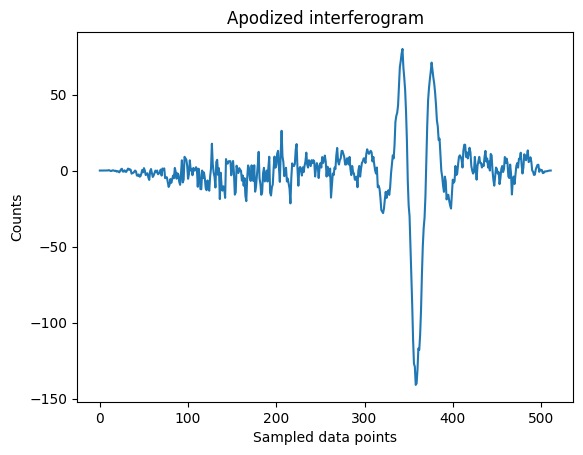

In [19]:
ai = apod * deglitched_ifg

plt.plot(ai)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Apodized interferogram")
plt.show()

Padding

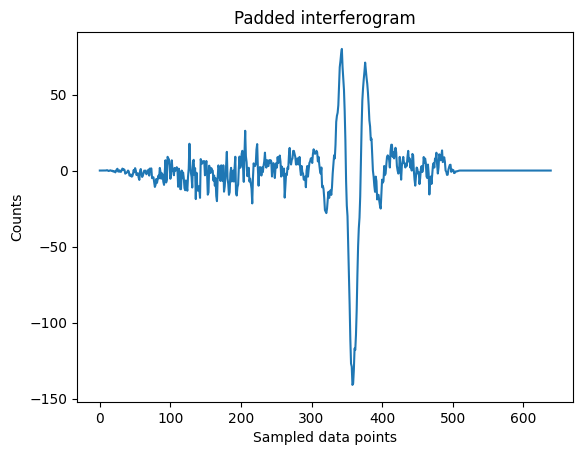

In [20]:
padding = np.zeros(640 - 512)
padded = np.concatenate((ai, padding))

plt.plot(padded)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Padded interferogram")
plt.show()

Roll

In [21]:
peak_pos = 360
rolled_ifg = np.roll(padded, -peak_pos)

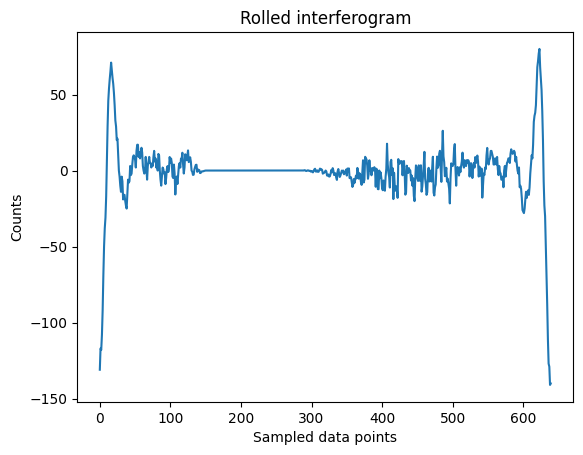

In [22]:
plt.plot(rolled_ifg)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Rolled interferogram")
plt.show()

Fourier transform

(321,)


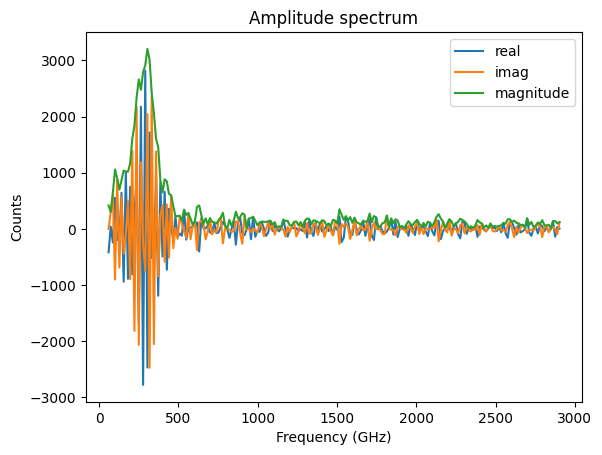

In [23]:
y = np.fft.rfft(padded)
print(y.real.shape)

# to do: roll and put real and imag

plt.plot(f, y.real[:210], label="real")
plt.plot(f, y.imag[:210], label="imag") 
plt.plot(f, np.abs(y)[:210], label='magnitude') # plotting the amplitude spectrum
plt.xlabel("Frequency (GHz)")
plt.ylabel("Counts")
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

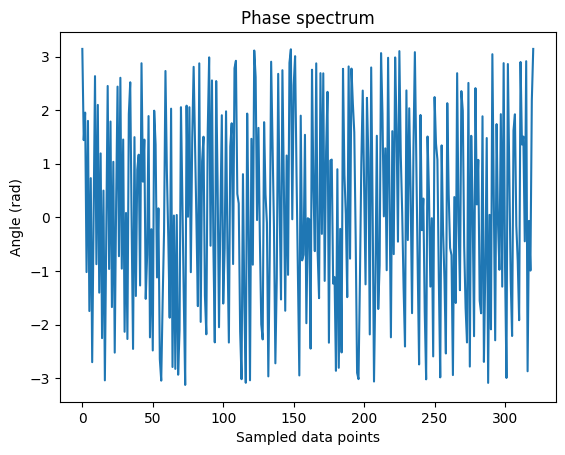

In [24]:
plt.plot(np.angle(y)) # plotting the phase spectrum
plt.xlabel("Sampled data points")
plt.ylabel("Angle (rad)")
plt.title("Phase spectrum")
plt.show()

Electronics transfer function to get the volts

In [25]:
from utils.frd import elex_transfcnl
from utils.fut import get_recnum

etfl_all = elex_transfcnl(samprate=681.43, nfreq=len(y.real))
erecno = get_recnum(fake_it, mtm_speed, channel, upmode, adds_per_group)
etf = etfl_all[erecno, :]

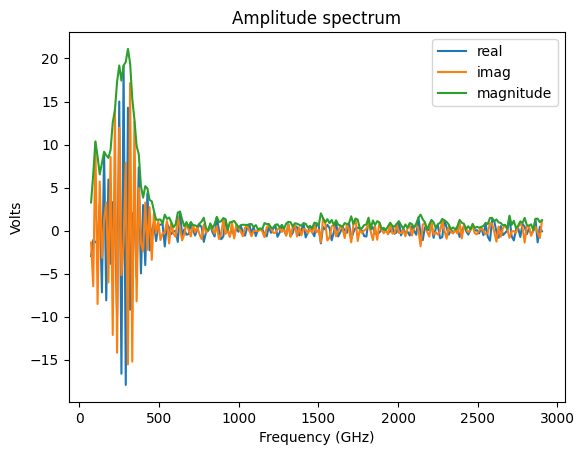

In [26]:
yz = y / etf * u.V

plt.plot(f, yz.real[:210], label="real")
plt.plot(f, yz.imag[:210], label="imag")
plt.plot(f, np.abs(yz)[:210], label='magnitude') # plotting the amplitude spectrum
plt.xlabel("Frequency (GHz)")
plt.ylabel("Volts")
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

In [27]:
# plt.plot(np.angle(yz)) # plotting the phase spectrum
# plt.ylabel("Angle (rad)")
# plt.title("Amplitude spectrum")
# plt.show()

Bolometer model

In [28]:
fits_data = fits.open('FIRAS_CALIBRATION_MODEL_LLSS.FITS')
fits_high = fits.open('FIRAS_CALIBRATION_MODEL_LHSS.FITS')
fits_data[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
DATE    = '24/09/97'           / FITS file creation date (dd/mm/yy)             
ORIGIN  = 'CDAC    '           /  Cosmology Data Analysis Center                
TELESCOP= 'COBE    '           /  COsmic Background Explorer satellite          
INSTRUME= 'FIRAS   '           /  COBE instrument [DIRBE, DMR, FIRAS]           
OBJECT  = 'ALL-SKY '        

In [29]:
tau = fits_data[1].data['TIME_CON'][0] * u.s
S0 = fits_data[1].data['DC_RESPO'][0] * u.V / u.W

In [30]:
domega = 2.2299744 * u.rad / u.s
omega = np.arange(210) * domega + 11.149872 * u.rad / u.s

In [31]:
bolometer = S0 / (1 + 1j * omega.value * tau.value)

W


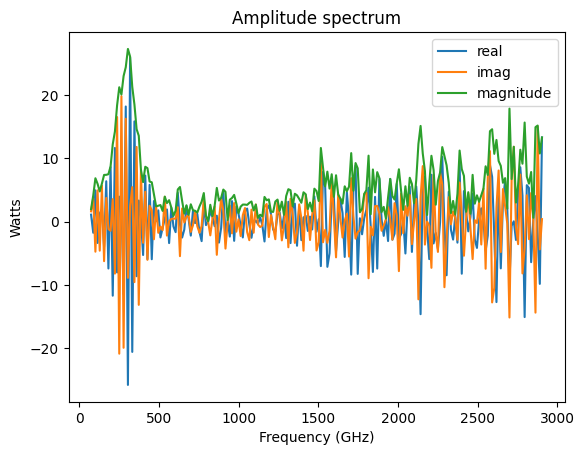

In [32]:
yzb = yz[:210] / bolometer[:210]
print(yzb.unit)

plt.plot(f, yzb.real[:210], label='real')
plt.plot(f, yzb.imag[:210], label='imag') 
plt.plot(f, np.abs(yzb)[:210], label='magnitude') # plotting the amplitude spectrum
plt.xlabel("Frequency (GHz)")
plt.ylabel("Watts")
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

In [33]:
# plt.plot(np.angle(yzb)) # plotting the phase spectrum
# plt.ylabel("Angle (rad)")
# plt.title("Amplitude spectrum")
# plt.show()

Cut off high frequencies

Mapping of correct frequencies to the points in the IFG and the given functions (OTF, etc)?

In [34]:
cutoff = yzb[:43]

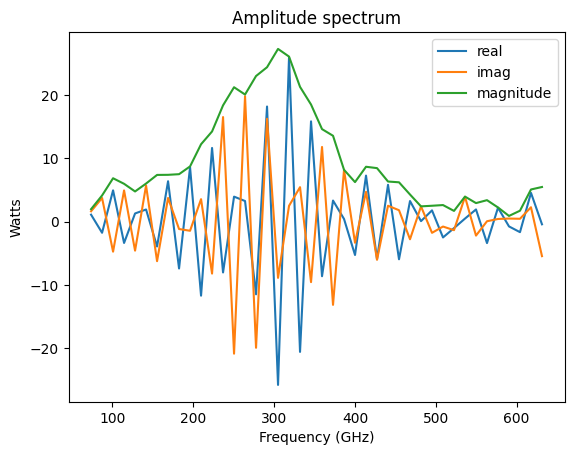

In [35]:
plt.plot(f[:43], cutoff.real, label='real')
plt.plot(f[:43], cutoff.imag, label='imag')
plt.plot(f[:43],np.abs(cutoff), label='magnitude') # plotting the amplitude spectrum
plt.xlabel("Frequency (GHz)")
plt.ylabel("Watts")
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

todo: missing vibration and corrections terms

Optical transfer function

43

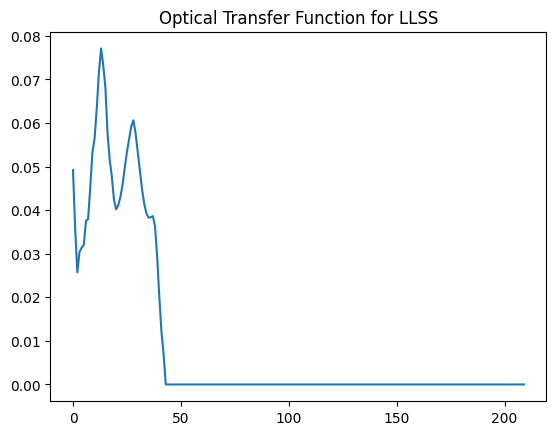

In [36]:
otf = fits_data[1].data["RTRANSFE"][0] + 1j * fits_data[1].data["ITRANSFE"][0]

plt.plot(np.abs(otf)) # plotting the amplitude spectrum
plt.title("Optical Transfer Function for LLSS")
len(otf[np.abs(otf) > 0])

In [37]:
# otf_high = fits_high[1].data["RTRANSFE"][0] + 1j * fits_high[1].data["ITRANSFE"][0]
# plt.plot(np.abs(otf_high)) # plotting the amplitude spectrum
# plt.title("Optical Transfer Function for LHSS")
# len(otf[np.abs(otf_high) > 0])

Why do we need to force the unit? Shoudldn't the OTF come with units? -- Problem with getting $D(\nu)$ into the right units

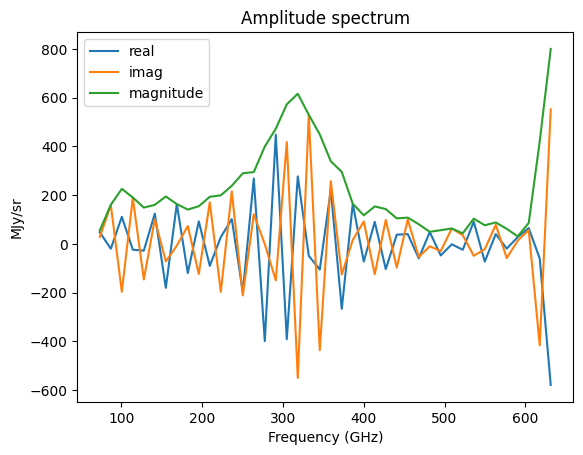

In [38]:
yzbh = cutoff / otf[:43]
yzbh = yzbh.value * u.MJy / u.sr

plt.plot(f[:43], yzbh.real, label='real')
plt.plot(f[:43], yzbh.imag, label='imag')
plt.plot(f[:43], np.abs(yzbh), label='magnitude') # plotting the amplitude spectrum
plt.title("Amplitude spectrum")
plt.xlabel("Frequency (GHz)")
plt.ylabel("MJy/sr")
plt.legend()
plt.show()

In [39]:
phase = 1e-5 * u.cm

d = np.exp(1j*nu[:43]*phase) * yzbh
d.unit

Unit("MJy / sr")

todo: recheck this?

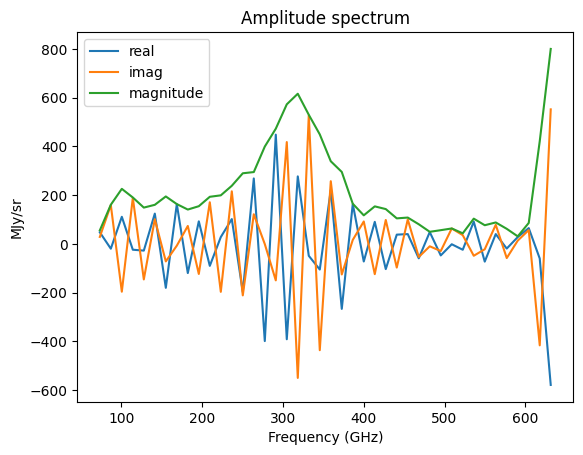

In [40]:
plt.plot(f[:43], d.real, label='real')
plt.plot(f[:43], d.imag, label='imag')
plt.plot(f[:43],np.abs(d), label='magnitude') # plotting the amplitude spectrum
plt.title("Amplitude spectrum")
plt.xlabel("Frequency (GHz)")
plt.ylabel("MJy/sr")
plt.legend()
plt.show()

In [41]:
ical_emiss = fits_data[1].data["RICAL"][0] + 1j * fits_data[1].data["IICAL"][0]

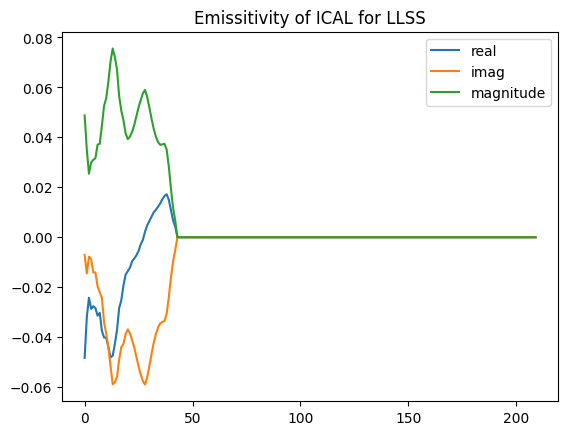

In [42]:
plt.plot(ical_emiss.real, label='real')
plt.plot(ical_emiss.imag, label='imag')
plt.plot(np.abs(ical_emiss), label='magnitude') # plotting the amplitude spectrum
plt.title("Emissitivity of ICAL for LLSS")
plt.legend()
plt.show()

In [43]:
t_ical = t_ical = (0.1 * fdq_eng["en_analog/grt/a_hi_ical"][eng_id] + 0.9 * fdq_eng["en_analog/grt/b_hi_ical"][eng_id]) * u.K

bb_ical1 = (BlackBody(temperature=t_ical)(f[:43]) * ical_emiss[:43]).to(u.MJy / u.sr)
bb_ical2 = (BlackBody(temperature=t_ical)(f[:43]) * 0.94).to(u.MJy / u.sr)


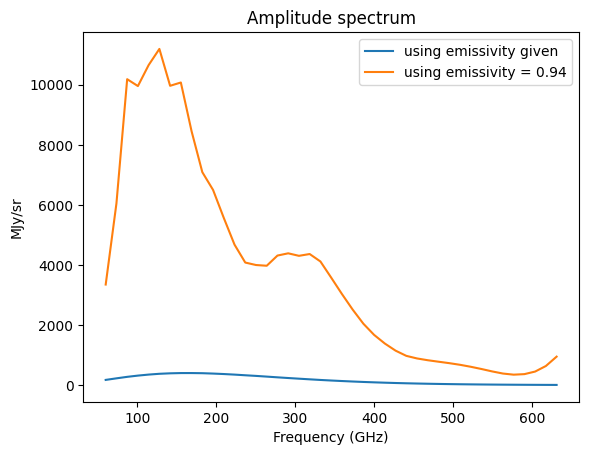

In [44]:
plt.plot(f[:43], np.abs(bb_ical1 / otf[:43]), label="using emissivity given") # plotting the amplitude spectrum
plt.plot(f[:43], np.abs(bb_ical2 / otf[:43]), label="using emissivity = 0.94") # plotting the amplitude spectrum
plt.title("Amplitude spectrum")
plt.xlabel("Frequency (GHz)")
plt.ylabel("MJy/sr")
plt.legend()
plt.show()

In [45]:
sky1 = d + bb_ical1 / otf[:43]
sky2 = d + bb_ical2 / otf[:43]

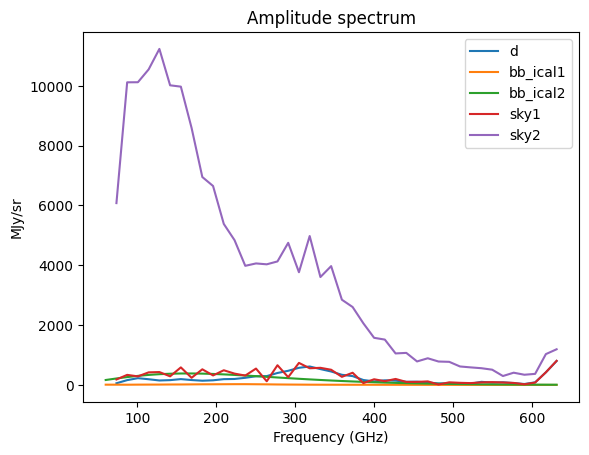

In [46]:
plt.plot(f[:43], np.abs(d), label="d")
plt.plot(f[:43], np.abs(bb_ical1), label="bb_ical1")
plt.plot(f[:43], np.abs(bb_ical2), label="bb_ical2")
plt.plot(f[:43], np.abs(sky1), label="sky1") # plotting the amplitude spectrum
plt.plot(f[:43], np.abs(sky2), label="sky2") # plotting the amplitude spectrum
plt.xlabel("Frequency (GHz)")
plt.ylabel("MJy/sr")
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

In [47]:
# plt.plot(np.angle(sky1), label='sky1') # plotting the phase spectrum
# plt.plot(np.angle(sky2), label='sky2') # plotting the phase spectrum
# plt.ylabel("Angle (rad)")
# plt.title("Phase spectrum")
# plt.legend()
# plt.show()

In [48]:
from scipy.optimize import curve_fit

def bb_model(x, t, scale):
    return (scale * BlackBody(t * u.K)(x)).to(u.MJy / u.sr).value

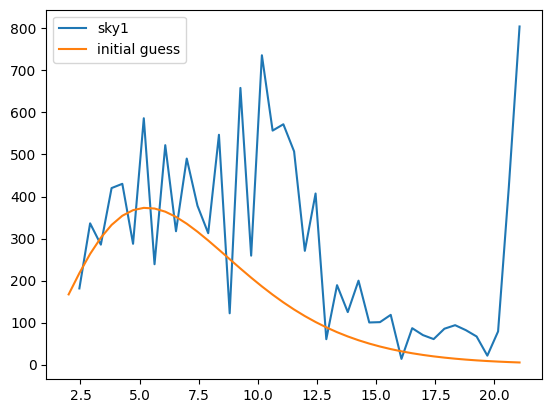

In [49]:
plt.plot(nu[:43], np.abs(sky1), label="sky1") # plotting the amplitude spectrum
p0 = [2.7, 1]
model = bb_model(f[:43], p0[0], p0[1])
plt.plot(nu[:43], model, label="initial guess")
plt.legend()
plt.show()

In [50]:
popt, pcov = curve_fit(f=bb_model, xdata=f[1:43], ydata=sky1[1:], p0 = p0, maxfev=800, bounds=(0, 1E10))

In [51]:
print(popt)

[2.7 1. ]


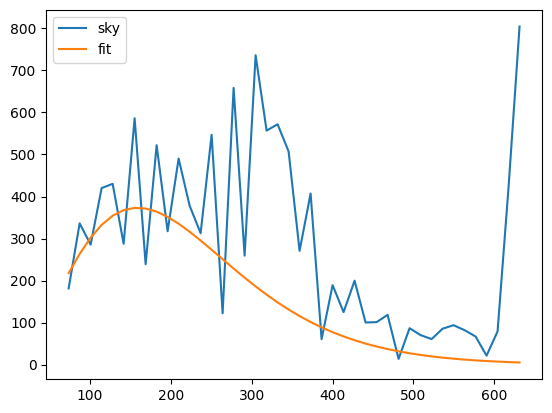

In [52]:
plt.plot(f[1:43], np.abs(sky1)[1:], label="sky")
plt.plot(f[1:43], bb_model(f[1:43], *popt), label="fit")
plt.legend()
plt.show()